<a href="https://colab.research.google.com/github/sandhyaaJha/Anime_generation/blob/main/Image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sandhyajha123
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:10<00:00, 39.7MB/s]


In [ ]:
import os
DATA_DIR = '/content/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR + '/images')[:10])

['18993_2007.jpg', '48491_2014.jpg', '60840_2018.jpg', '20978_2008.jpg', '6241_2003.jpg', '14176_2006.jpg', '24125_2008.jpg', '16532_2006.jpg', '47770_2014.jpg', '51376_2015.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

**image_size =  the images will be resized to 64x64 pixels before processing.**


**batch_size = model will process 128 images at a time during training or evaluation.**


**stats = mean for RGB channels , standard deviation for RGB channels**.
**These values represent normalization for image data**

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5) , (0.5,0.5,0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR , transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

**num_worker = controls number of subprocess used for data loading**

**num_worker = 0 : only the main process will load the batches.**

**num_worker = 3 : DataLoader will use 3 separate process to load data in parallel.**

**pin_memory = True : DataLoader will automatically put fetched data Tensors in pin memory.**
**Enables fast data transfer to cuda enable GPUs.**

In [ ]:
train_dl = DataLoader(train_ds , batch_size , shuffle = True , num_workers = 2 , pin_memory = True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images , nmax=64):
    fig , ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]),ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]) , nrow=8).permute(1,2,0))
def show_batch(dl,nmax=64):
    for images , _ in dl:
        show_images(images , nmax)
        break


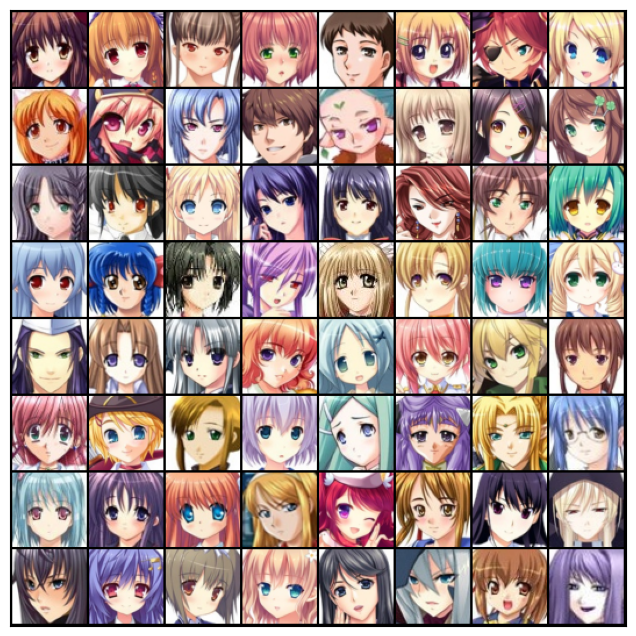

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data , device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    def __init__(self , dl , device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b , self.device)
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
print(device)

cuda


In [ ]:
train_dl = DeviceDataLoader(train_dl , device)

In [ ]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
import jovian

In [ ]:
jovian.commit(project="image-generation", environment=None)


[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


**Discriminator Network**

In [ ]:
import torch.nn as nn

**3(in channels) = Number of input Channels**


**64(out channels) = Number of output Channels(filter/kernels)**




**stride = 2 : step size for moving filter.**


**padding = 1 : adds of 1-pixel border around the input(preserves spatial size)**


**bias = False : No bias term from convolution operation**


**output = input * filter + bias**


**kernel_size = 4 : size of convolutio filter 4*4 window**

**inplace = True : data is modified in place which means it  will return nothing and dataframe is now updated**.

In [ ]:
discriminator = nn.Sequential(
    # in 3*64*64
    nn.Conv2d(3,64,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    #out 64*32*32

    nn.Conv2d(64,128,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    # out 128*16*16

    nn.Conv2d(128,256,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    # out 256*8*8

    nn.Conv2d(256,512,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    # out 512*4*4

    nn.Conv2d(512,1,kernel_size = 4 , stride = 1 , padding = 0 , bias = False),
    # out 1*1*1

    nn.Flatten(),
    nn.Sigmoid()
)


In [ ]:
discriminator = to_device(discriminator , device)

# Generator Network

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in 128*1*1
    nn.ConvTranspose2d(latent_size , 512 , kernel_size = 4 ,stride = 1 , padding = 0 , bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out 512*4*4

    nn.ConvTranspose2d(512,256,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out 256*8*8

    nn.ConvTranspose2d(256,128,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out 128*16*16

    nn.ConvTranspose2d(128,64,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out 64*32*32

    nn.ConvTranspose2d(64,3,kernel_size = 4 , stride = 2 , padding = 1 , bias = False),
    nn.Tanh()
    # out 64*3*3


)

torch.Size([128, 3, 64, 64])


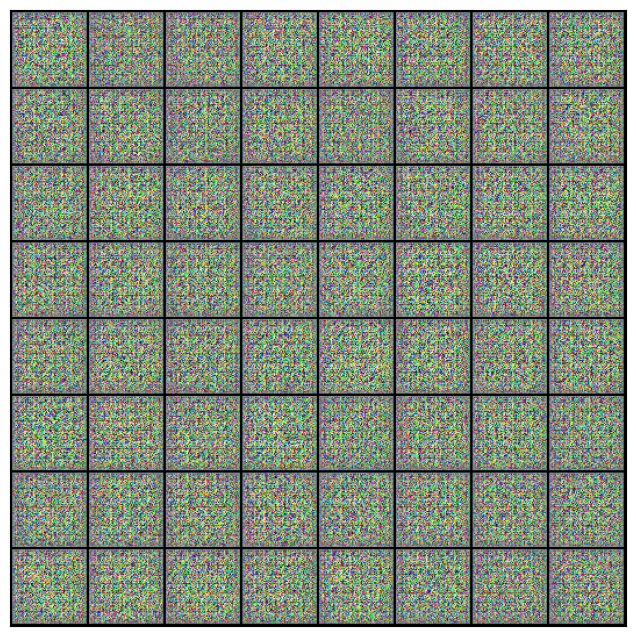

In [ ]:
xb = torch.randn(batch_size , latent_size , 1 , 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [ ]:
generator = to_device(generator , device)

**Discriminator Training**

In [ ]:
def train_discriminator(real_images , opt_d):
    # clear discriminator gradients
    opt_d.zero_grad()
    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds , real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake images
    latent = torch.randn(batch_size , latent_size , 1 , 1 , device = device)
    fake_images = generator(latent)

    # pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_loss = F.binary_cross_entropy(fake_preds , fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # update discriminator weights
    loss = real_loss + fake_loss
    # backward propagation
    loss.backward()
    # update parameters
    opt_d.step()
    return loss.item() , real_score , fake_score

**Generator Training**

In [ ]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()
    # Generate Fake images
    latent = torch.randn(batch_size , latent_size , 1 , 1 , device=device)
    fake_images = generator(latent)
    # Try to fool discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size , 1 , device = device)
    loss = F.binary_cross_entropy(preds, targets)

    # update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir , exist_ok = True)

In [ ]:
def save_samples(index , latent_tensors , show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64,latent_size , 1 , 1 , device = device)

Saving generated-images-0000.png


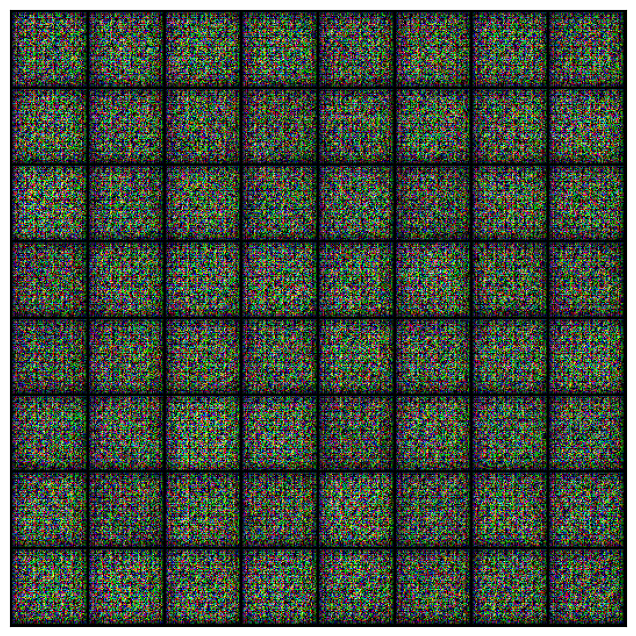

In [ ]:
save_samples(0,fixed_latent)

**Full Training Loop**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

**tqdm : python library designed to monitor progress of your code**.

**A higher beta value results in slower update towards the optimal solution as the optimizer heavily relies on past gradients**

**A lower beta value leads to faster updates but can be more susceptible to noisy gradients**.

**beta_1 and beta_2: A float value or constant value tensor or callable that takes no argument and return the actual values to use**.

**By default , beta_1 = 0.9 and beta_2 = 0.999**

In [ ]:
def fit(epochs , lr , start_idx=1):
    torch.cuda.empty_cache()

    # Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters() , lr = lr , betas = (0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters() , lr = lr , betas = (0.5,0.999))
    for epoch in range(epochs):
        for real_images , _ in tqdm(train_dl):
            # Train discriminator
            loss_d , real_score , fake_score = train_discriminator(real_images , opt_d)

            # Train generator
            loss_g = train_generator(opt_g)
        # record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)


        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # save generated images
        save_samples(epoch+start_idx , fixed_latent , show = False)
    return losses_g , losses_d , real_scores , fake_scores


In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs , lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 8.4686, loss_d: 1.0060, real_score: 0.8634, fake_score: 0.5261
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 8.3645, loss_d: 0.7838, real_score: 0.8947, fake_score: 0.4363
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.1995, loss_d: 0.3682, real_score: 0.9178, fake_score: 0.2214
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.9927, loss_d: 0.1283, real_score: 0.9202, fake_score: 0.0284
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 8.5750, loss_d: 0.3730, real_score: 0.9185, fake_score: 0.2136
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 7.1597, loss_d: 0.1161, real_score: 0.9194, fake_score: 0.0052
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.3586, loss_d: 0.0611, real_score: 0.9665, fake_score: 0.0223
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.4163, loss_d: 0.0740, real_score: 0.9797, fake_score: 0.0497
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.6784, loss_d: 0.0665, real_score: 0.9600, fake_score: 0.0180
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 9.4033, loss_d: 0.0477, real_score: 0.9582, fake_score: 0.0014
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 9.6075, loss_d: 0.1966, real_score: 0.9741, fake_score: 0.1449
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 7.2292, loss_d: 0.0065, real_score: 0.9964, fake_score: 0.0028
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 9.4149, loss_d: 0.0678, real_score: 0.9880, fake_score: 0.0518
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 10.3253, loss_d: 0.1421, real_score: 0.9904, fake_score: 0.1153
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 14.2917, loss_d: 0.0166, real_score: 0.9848, fake_score: 0.0004
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 7.0854, loss_d: 0.0530, real_score: 0.9720, fake_score: 0.0203
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 23.2522, loss_d: 0.5528, real_score: 0.9923, fake_score: 0.2054
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 7.0125, loss_d: 0.0495, real_score: 0.9865, fake_score: 0.0312
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.6643, loss_d: 0.1288, real_score: 0.9272, fake_score: 0.0322
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 18.8198, loss_d: 2.4195, real_score: 0.3397, fake_score: 0.0000
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 17.1914, loss_d: 0.2883, real_score: 0.9875, fake_score: 0.2286
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 7.4485, loss_d: 0.0472, real_score: 0.9622, fake_score: 0.0026
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 9.2709, loss_d: 0.1196, real_score: 0.9847, fake_score: 0.0947
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 8.2219, loss_d: 0.0076, real_score: 0.9992, fake_score: 0.0067
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 6.5296, loss_d: 0.0462, real_score: 0.9922, fake_score: 0.0363
Saving generated-images-0025.png


In [ ]:
losses_g , losses_d , real_scores , fake_scores = history

In [ ]:
# save the model checkpoints
torch.save(generator.state_dict(),'G.ckpt')
torch.save(discriminator.state_dict(),'D.ckpt')

In [ ]:
from IPython.display import Image

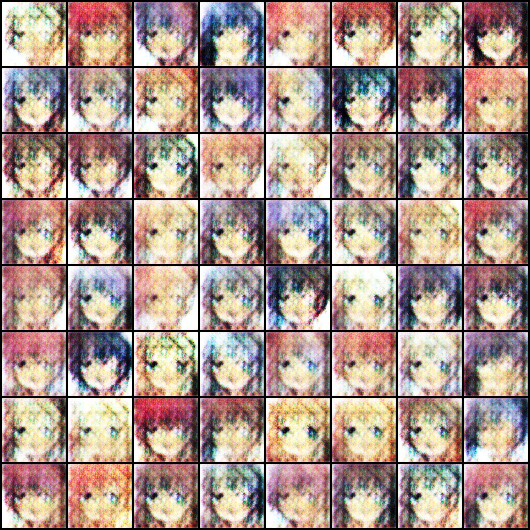

In [ ]:
Image('./generated/generated-images-0001.png')

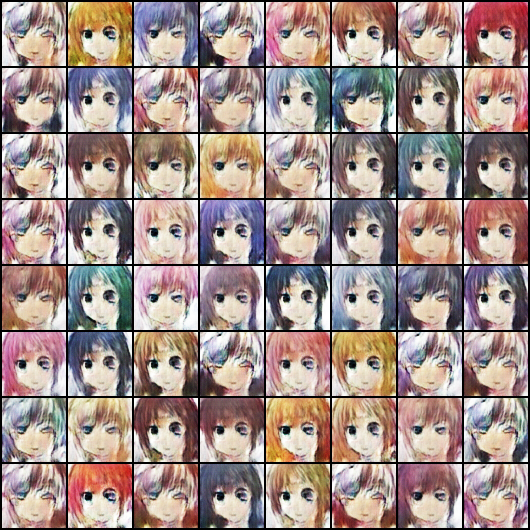

In [ ]:
Image('./generated/generated-images-0012.png')

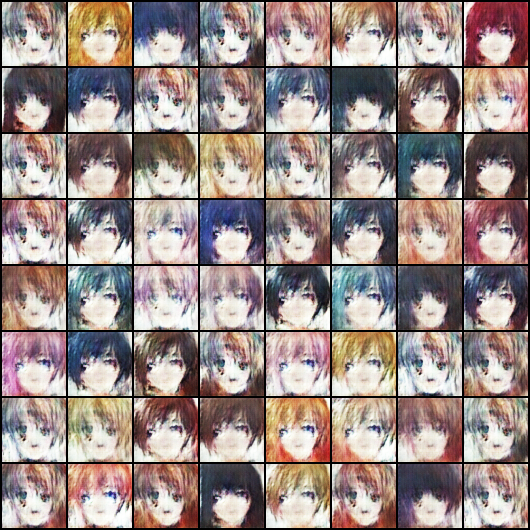

In [ ]:
Image('./generated/generated-images-0017.png')

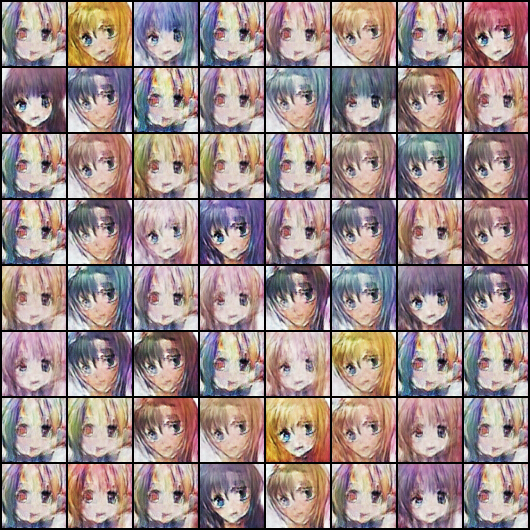

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Losses')

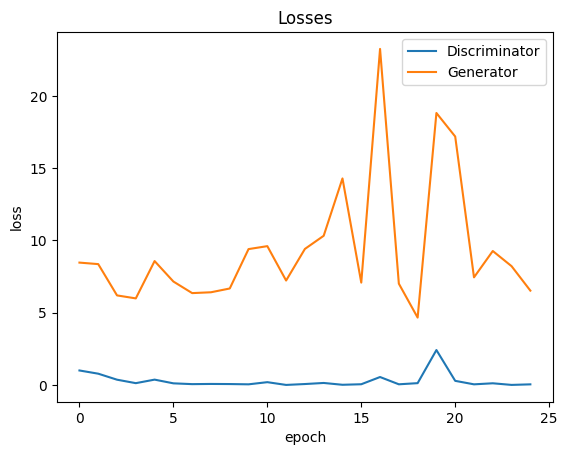

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

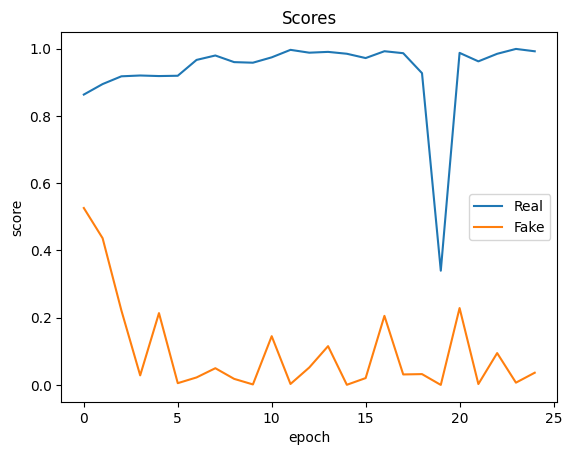

In [ ]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real','Fake'])
plt.title('Scores')